# Preamble

Theodore Barnhart | tbarnhart@usgs.gov | theodore.barnhart@colorado.edu | April 6, 2019

This notebook explores global parameter sensivitivty using the dela-moment method (Plischke et al., 2013).

This is done via three analyses on two datasets, making six sensitivity analysese:

**Analysis 1:**
SA is run on outputs with only optimized rooting depth (combo == 6)

**Analysis 2:**
SA is run on outputs with all rooting depths to assess the importance of plant available water storage (PAWS).

**Analysis 3:**
SA is run on outputs with all rooting depths and sites.

**Dataset 1:**
Ablation season runoff ratio (abblRR_ET)

**Dataset 2:**
Ablation season change in subsurface storage (wb)

## Notes for the WRR revision

- Add Evaporation and transpiration to the GSA
- Do a parallel GSA using whole year data

In [1]:
import pandas as pd
from SALib.analyze import delta
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

## Load Data

In [2]:
delta

<module 'SALib.analyze.delta' from '/Users/barnhatb/anaconda/envs/py3/lib/python3.7/site-packages/SALib/analyze/delta.py'>

In [3]:
# load data
site = 'Nr1'
exname = 'smex8_sen'
method = '8'
period = 'melt'
Nr1 = pd.read_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df') # load the first experiment
Nr1['site'] = 'Nr1'

site = 'p301'
exname = 'smex8_sen'
method = '8'
period = 'melt'
P301 = pd.read_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df')
P301['site'] = 'P301'

In [4]:
Nr1.columns

Index(['MAP', 'PeakSWE', 'SMR', 'TpeakSWE', 'combo', 'idx', 'rd', 'ref',
       'scenidx', 'sd', 'T', 'E', 'ET', 'Q', 'Qbf', 'Qrf', 'rech', 'sat', 'p',
       'rz_storage', 'rz_drainage', 'unsat_storage', 'unsat_drainage',
       'sat_def', 'sat_def_z', 'sm', 'gwStore', 'gwFlux', 'ETRate', 'Pmodel',
       'Pex', 'wb', 'wb_PeakSWE', 'E_PeakSWE', 'T_PeakSWE', 'RR', 'ablRR',
       'RR_ET', 'ablRR_ET', 'SMR_PeakSWE', 'TpeakSWE_PeakSWE', 'ablRR2', 'RR2',
       'RR_ET2', 'ablRR_ET2', 'SMR2', 'PeakSWE2', 'TpeakSWE2', 'SMR_PeakSWE2',
       'TpeakSWE_PeakSWE2', 'wb2', 'site'],
      dtype='object')

In [5]:
# clean the data to remove scenarios where ET is greater than snowmelt
Nr1 = Nr1.loc[Nr1.ablRR_ET>0]
P301 = P301.loc[P301.ablRR_ET>0]

In [6]:
Nr1.combo.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [7]:
dat = pd.concat([Nr1,P301])

In [8]:
# define problem
problem1 = {
    'num_vars': 2,
    'names': ['SMR', 'TpeakSWE'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

problem2 = {
    'num_vars': 3,
    'names': ['SMR', 'TpeakSWE','rd'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

problem3 = {
    'num_vars': 4,
    'names': ['SMR', 'TpeakSWE', 'rd','site'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

In [11]:
#resamp = 50 # use for final
resamp = 10
console = False

Yvars = []
Sites = []
outputs = []
Problems = []
for Yvar in ['wb','T_PeakSWE','E_PeakSWE','ablRR_ET','rz_storage','gwStore']:
    for problem in [problem1,problem2,problem3]:
        for site in ['Nr1','P301','All']:
            if site != 'All': # if a specific site is requested
                if problem['num_vars'] > 2: # use all the rooting depths
                    Y = dat.loc[(dat.site == site),Yvar].values.astype(np.float32)
                    X = dat.loc[(dat.site == site),problem['names']].values
                else: # if the analysis includes only two variables, use optimal PAWS
                    Y = dat.loc[(dat.site == site) & (dat.combo == 6),Yvar].values
                    X = dat.loc[(dat.site == site) & (dat.combo == 6),problem['names']].values
            else: # otherwise use all the sites
                Y = dat[Yvar].values
                X = dat[problem['names']].values
                
            Yvars.append(Yvar)
            Sites.append(site)
            outputs.append(delta.analyze(problem, X, Y, print_to_console=console, num_resamples=resamp))
            Problems.append(problem)
    print(Yvar)

wb
T_PeakSWE
E_PeakSWE
ablRR_ET
rz_storage
gwStore


In [12]:
np.unique(Yvars)

array(['E_PeakSWE', 'T_PeakSWE', 'ablRR_ET', 'gwStore', 'rz_storage',
       'wb'], dtype='<U10')

In [136]:
# process the results
dfs = []

for Yvar,site,output,problem in zip(Yvars,Sites,outputs,Problems):
    df = pd.DataFrame()
    
    df['delta'] = output['delta']/output['delta'].max() # scale from 0 to 1
    df['error'] = output['delta_conf']/output['delta'].max() # scale the error in the same way
    df['parameter'] = problem['names']
    df['variable'] = Yvar
    df['site'] = site
    df['problem'] = len(problem['names']) - 1
    
    dfs.append(df)
    
df = pd.concat(dfs)

In [137]:
def param2num(param):
    if param == 'SMR':
        return 1
    if param == 'TpeakSWE':
        return 2
    if param == 'rd':
        return 3
    if param == 'site':
        return 4

In [138]:
df['paramNum'] = df.parameter.map(param2num)

In [16]:
df.to_pickle('./data/si_analysis_revision.pcl')

In [139]:
df.loc[(df.site == 'Nr1'),'paramNum'] += 0.1
df.loc[(df.site == 'P301'),'paramNum'] -= 0.1

In [49]:
df.head()

,delta,error,parameter,variable,site,problem,paramNum,size
0,0.699958,0.008204,SMR,wb,Nr1,1,1.1,100.0
1,1.000000,0.005639,TpeakSWE,wb,Nr1,1,2.1,100.0
0,0.991246,0.008662,SMR,wb,P301,1,0.9,50.0
1,1.000000,0.010128,TpeakSWE,wb,P301,1,1.9,50.0
0,0.709716,0.001534,SMR,wb,All,1,1.0,100.0


In [19]:
df['size'] = 100.
df.loc[df.site == 'P301','size'] = 50.

In [20]:
df.loc[(df.site == 'Nr1') & (df.variable == 'E_PeakSWE')]

,delta,error,parameter,variable,site,problem,paramNum,size
0,0.897471,0.004091,SMR,E_PeakSWE,Nr1,1,1,100.0
1,1.000000,0.007124,TpeakSWE,E_PeakSWE,Nr1,1,2,100.0
0,1.000000,0.002076,SMR,E_PeakSWE,Nr1,2,1,100.0
1,0.810973,0.001727,TpeakSWE,E_PeakSWE,Nr1,2,2,100.0
2,0.126839,0.001779,rd,E_PeakSWE,Nr1,2,3,100.0
0,1.000000,0.002846,SMR,E_PeakSWE,Nr1,3,1,100.0
1,0.811329,0.002143,TpeakSWE,E_PeakSWE,Nr1,3,2,100.0
2,0.127011,0.001470,rd,E_PeakSWE,Nr1,3,3,100.0
3,0.260116,0.000834,site,E_PeakSWE,Nr1,3,4,100.0


In [91]:
df['site'] = df.site.astype('category')

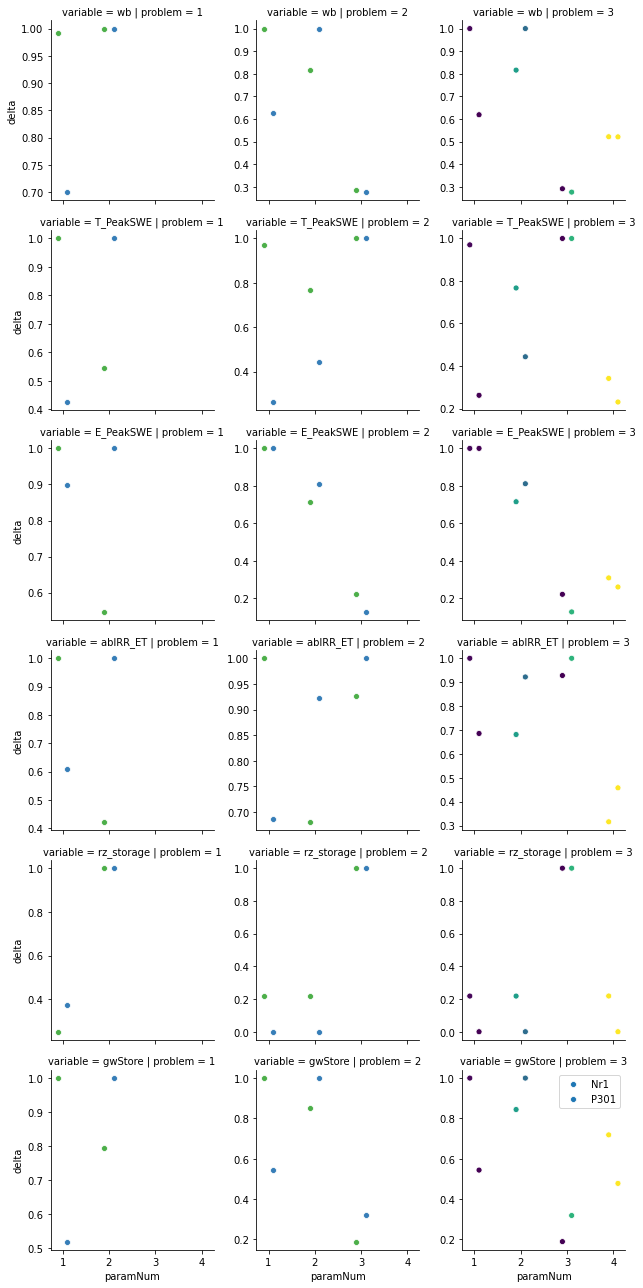

In [98]:
hueOrder = list(df.site.unique())
g = sns.FacetGrid(df.loc[df.site != 'All'], col = 'problem', row = 'variable',
                  sharey=False, palette = 'Set1', hue = 'site')
axes = g.map(sns.scatterplot,'paramNum','delta')
plt.legend()

<function matplotlib.pyplot.legend(*args, **kwargs)>

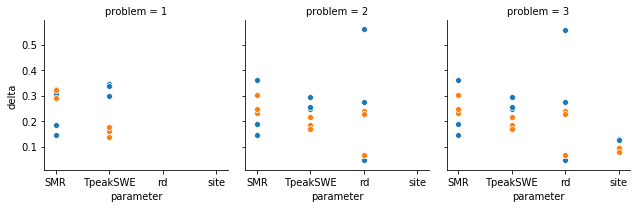

In [116]:
g = sns.FacetGrid(df.loc[(df.site != 'All') & (df.variable.isin(['E_PeakSWE','T_PeakSWE','ablRR_ET']))],
                  col='problem', hue='site')
g.map(sns.scatterplot,'parameter','delta')
plt.legend

# Plotting

Make one two pannel plot with runoff on the left and change in subsurface storage on the right

Colors == different SA problems

Symbols == different sites

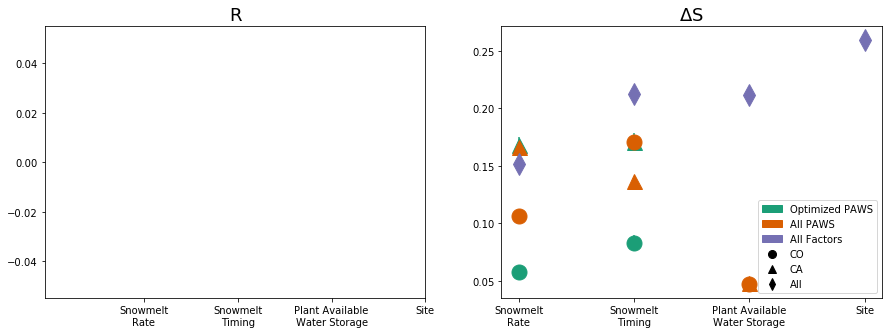

In [29]:
tmps = []
titleFont = 18
markerSize = 15
xlabels = ['Snowmelt\nRate', 'Snowmelt\nTiming','Plant Available\nWater Storage','Site']
xticks = np.arange(1,len(xlabels)+1)

problems = [1,2,3]
colors = ['#1b9e77','#d95f02','#7570b3']
sites = ['Nr1','P301','All']
siteLabels = ['CO','CA','All']
siteSymbs = ['o','^','d']
titles = ['R','$\Delta$S']
variables = ['ablRR_ET','wb']

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

axs = [ax1,ax2]
for ax,title,var in zip(axs,titles,variables):
    plt.sca(ax)
    plt.title(title, fontsize = titleFont)

    for problem,color in zip(problems,colors):
        #sites = df.loc[(df.problem == problem) & (df.variable == var)].site.unique()
        if problem < 3:
            sites = ['Nr1','P301']
        else:
            sites = ['All']
        for i,site in enumerate(sites):
            label = siteLabels[i]
            symb = siteSymbs[i]

            if len(sites) == 1:
                label = siteLabels[2]
                symb = siteSymbs[2]

            tmp = df.loc[(df.problem == problem) & (df.site == site) & (df.variable == var)]

            ax.errorbar(tmp.paramNum, tmp.delta, yerr=tmp.error, fmt=symb, color = color, label = label,
                         markersize = markerSize)
            tmps.append(tmp)

        plt.xticks(ticks = xticks, labels = xlabels)

# do the legend
custom_lines = [Patch(facecolor=colors[0], edgecolor=colors[0],label='Optimized PAWS'),
                Patch(facecolor=colors[1], edgecolor=colors[1],label='All PAWS'),
                Patch(facecolor=colors[2], edgecolor=colors[2],label='All Factors'),
                Line2D([0], [0], color='k', marker=siteSymbs[0], lw=0, markersize=8,label = 'CO'),
                Line2D([0], [0], color='k', marker=siteSymbs[1], lw=0, markersize=8, label = 'CA'),
                Line2D([0], [0], color='k', marker=siteSymbs[2], lw=0, markersize=8, label = 'All')]
                       
plt.legend(handles=custom_lines);

# Little confusing, break in to 6 panels:

In [88]:
df.variable.unique()

array(['wb', 'T_PeakSWE', 'E_PeakSWE', 'ablRR_ET', 'rz_storage',
       'gwStore'], dtype=object)

In [100]:
df.head()

,delta,error,parameter,variable,site,problem,paramNum,size
0,0.699958,0.008204,SMR,wb,Nr1,1,1.1,100.0
1,1.000000,0.005639,TpeakSWE,wb,Nr1,1,2.1,100.0
0,0.991246,0.008662,SMR,wb,P301,1,0.9,50.0
1,1.000000,0.010128,TpeakSWE,wb,P301,1,1.9,50.0
0,0.709716,0.001534,SMR,wb,All,1,1.0,100.0


In [112]:
df.loc[(df.site == 'All') & (df.variable == 'wb') & (df.problem == 3)]

,delta,error,parameter,variable,site,problem,paramNum,size
0,0.585046,0.001564,SMR,wb,All,3,1.0,100.0
1,0.821384,0.002011,TpeakSWE,wb,All,3,2.0,100.0
2,0.820356,0.002435,rd,wb,All,3,3.0,100.0
3,1.000000,0.000590,site,wb,All,3,4.0,100.0


In [103]:
df.problem.unique()

array([1, 2, 3])

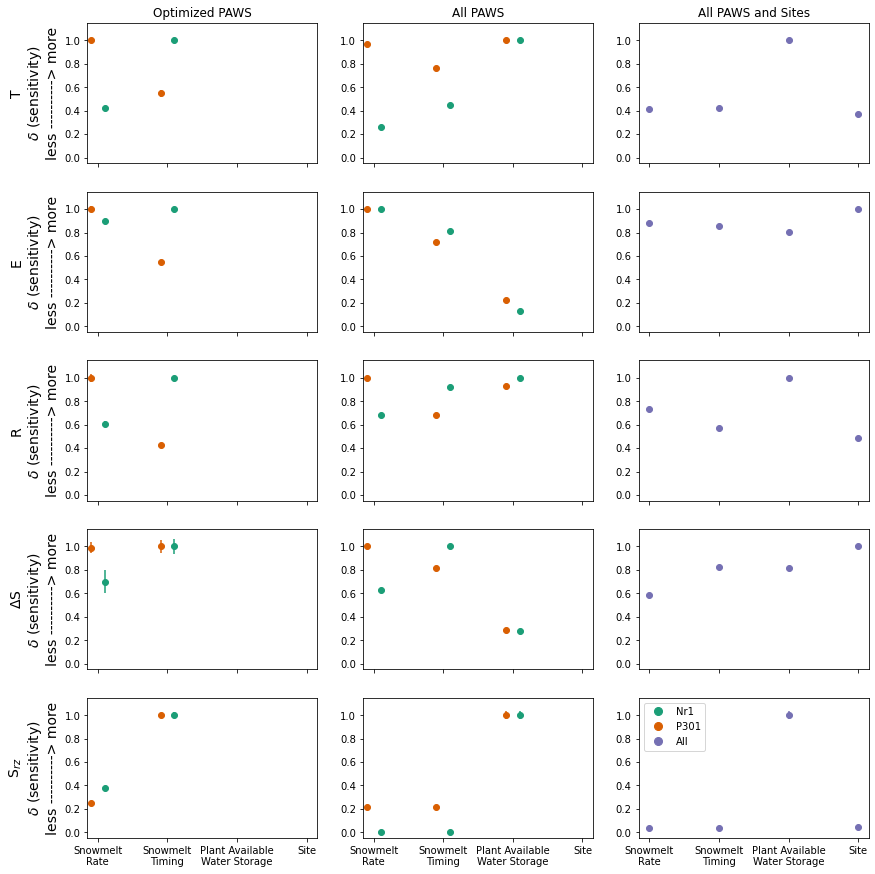

In [143]:
tmps = []
titleFont = 18
markerSize = 15
xlabels = ['Snowmelt\nRate', 'Snowmelt\nTiming','Plant Available\nWater Storage','Site']
xticks = np.arange(1,len(xlabels)+1)

titles2 = ['Optimized PAWS','All PAWS','All PAWS and Sites']

problems = [1,2,4]
colors = ['#1b9e77','#d95f02','#7570b3']
sites = ['Nr1','P301','All']
siteLabels = ['Nr1','P301','All']
siteSymbs = ['o','^','d']
titles = ['T','E','R','$\Delta$S','S$_{rz}$']
variables = ['T_PeakSWE','E_PeakSWE','ablRR_ET','wb','rz_storage']

# do the legend
custom_lines = [Line2D([0], [0], color=colors[0], marker='o', lw=0, markersize=8,label = 'Nr1'),
                Line2D([0], [0], color=colors[1], marker='o', lw=0, markersize=8, label = 'P301'),
                Line2D([0], [0], color=colors[2], marker='o', lw=0, markersize=8, label = 'All')]

fig,a = plt.subplots(nrows=5, ncols=3, figsize=(14,15))

for i,var in enumerate(variables):
    for k,p in enumerate(problems):
    
        if p < 4:
            tmp = df.loc[(df.site != 'All') & (df.problem == p) & (df.variable == var)]
            for j,site in enumerate(['Nr1','P301']):
                t = tmp.loc[tmp.site == site]
                a[i][k].errorbar(x=t.paramNum, y=t.delta, yerr = t.error, color=colors[j], fmt = 'o')
                if i == 0: a[i][k].set_title(titles2[k])
                if k == 0: a[i][k].set_ylabel('%s\n$\delta$ (sensitivity)\nless ----------> more'%titles[i],
                                              fontsize = 14)
        else:
            t = df.loc[(df.variable == var) & (df.site == 'All') & (df.problem == p-1)]
            a[i][k].errorbar(x=t.paramNum, y=t.delta, yerr = t.error, color=colors[2], fmt='o')
            if i == 0:
                    a[i][k].set_title(titles2[k])
                    
        a[i][k].set_xlim(0.85,4.15)
        a[i][k].set_ylim(-0.05,1.15)
        a[i][k].set_xticks([1,2,3,4])
        a[i][k].set_xticklabels([])
        if i == 4:
            a[i][k].set_xticklabels(xlabels)
            
plt.sca(a[4][2])
plt.legend(handles = custom_lines)

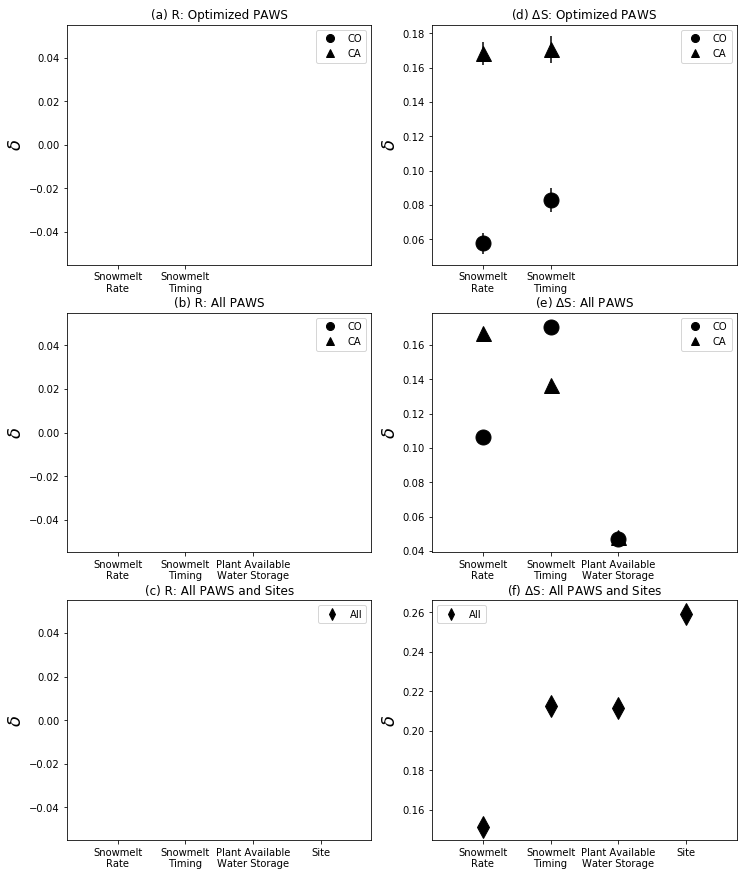

In [30]:
tmps = []
titleFont = 18
markerSize = 15
xlabels = ['Snowmelt\nRate', 'Snowmelt\nTiming','Plant Available\nWater Storage','Site']
xticks = np.arange(1,len(xlabels)+1)

titles2 = ['Optimized PAWS','All PAWS','All PAWS and Sites']

problems = [1,2,3]
colors = ['#1b9e77','#d95f02','#7570b3']
sites = ['Nr1','P301','All']
siteLabels = ['Nr1','P301','All']
siteSymbs = ['o','^','d']
titles = ['T','E','R','$\Delta$S','S$_{rz}$']
variables = ['T_PeakSWE','E_PeakSWE','ablRR_ET','wb','rz_storage']

#fig = plt.figure(figsize=(12,15))
#ax1 = fig.add_subplot(541)
#ax2 = fig.add_subplot(542)
#ax3 = fig.add_subplot(543)
#ax4 = fig.add_subplot(544)
#ax5 = fig.add_subplot(545)
#ax6 = fig.add_subplot(546)
#ax7 = fig.add_subplot(546)
#ax8 = fig.add_subplot(546)
#ax9 = fig.add_subplot(546)
#ax10 = fig.add_subplot(546)
#ax11 = fig.add_subplot(546)
#ax12 = fig.add_subplot(546)
#ax13 = fig.add_subplot(546)
#ax14 = fig.add_subplot(546)
#ax15 = fig.add_subplot(546)

# do the legend
custom_lines = [Line2D([0], [0], color='k', marker=siteSymbs[0], lw=0, markersize=8,label = 'Nr1'),
                Line2D([0], [0], color='k', marker=siteSymbs[1], lw=0, markersize=8, label = 'P301'),
                Line2D([0], [0], color='k', marker=siteSymbs[2], lw=0, markersize=8, label = 'All')]

axes = [
    [ax1,ax2,ax3,ax4], # E
    [ax5,ax6,ax7,ax8], # T
    [ax9,ax10,ax11,ax12], # R
    [ax13,ax14,ax15,ax16], # wb
    [ax17,ax18,ax19,ax20], # rz
       ] 

for axs,title,var in zip(axes,titles,variables):
    for ax,problem in zip(axs,problems):
        plt.sca(ax)
        plt.title(title, fontsize = titleFont)
        #sites = df.loc[(df.problem == problem) & (df.variable == var)].site.unique()
        if problem < 3:
            sites = ['Nr1','P301']
        else:
            sites = ['All']
        for i,site in enumerate(sites):
            label = siteLabels[i]
            symb = siteSymbs[i]

            if len(sites) == 1:
                label = siteLabels[2]
                symb = siteSymbs[2]

            tmp = df.loc[(df.problem == problem) & (df.site == site) & (df.variable == var)]

            ax.errorbar(tmp.paramNum, tmp.delta, yerr=tmp.error, fmt=symb, color = 'k', label = label,
                         markersize = markerSize)
            tmps.append(tmp)
            plt.xlim(0.25,4.75)
            plt.xticks(ticks = xticks[0:problem+1], labels = xlabels[0:problem+1])
            
            l = len(sites)
            if l == 1:
                plt.legend(handles=[custom_lines[2]]);
            else:
                plt.legend(handles=custom_lines[0:l]);
            
for ax,title,lab in zip([ax1,ax3,ax5],titles2, ['(a)','(b)','(c)']):
    ax.set_ylabel('$\delta$', fontsize = 18)
    ax.set_title('%s R: %s'%(lab,title))
    
for ax,title,lab in zip([ax2,ax4,ax6],titles2,['(d)','(e)','(f)']):
    ax.set_ylabel('$\delta$', fontsize = 18)
    ax.set_title('%s $\Delta$S: %s'%(lab,title))
    
plt.savefig("./figures/SI_analysis_6panel.pdf", bbox_inches='tight')
plt.savefig("./figures/SI_analysis_6panel.png", bbox_inches='tight', dpi=300)